In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct

def read_idx(filename):
    '''A function to read idx file format into numpy array'''
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
train_set = read_idx('train-images-idx3-ubyte (1)')
train_set = np.expand_dims(train_set, axis=3)
print(train_set.shape)
train_label = read_idx('train-labels-idx1-ubyte (1)')
train_label = np.expand_dims(train_label, axis=1)
print(train_label.shape)

test_set = read_idx('t10k-images-idx3-ubyte (1)')
test_set = np.expand_dims(test_set, axis=3)
print(test_set.shape)
test_label = read_idx('t10k-labels-idx1-ubyte (1)')
test_label = np.expand_dims(test_label, axis=1)
print(test_label.shape)
n_train = train_set.shape[0]
n_test = test_set.shape[0]

(60000, 28, 28, 1)
(60000, 1)
(10000, 28, 28, 1)
(10000, 1)


C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [5]:
def one_hot(labels):
    """
    Encodes the labels as one-hot vectors. Zero is represented as 10 in SVHN.
    [10] -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    """
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

train_label_one_hot = one_hot(train_label)
test_label_one_hot = one_hot(test_label)

print(train_label_one_hot.shape)
print(test_label_one_hot.shape)

(60000, 10)
(10000, 10)


In [6]:
class SVHN_CNN:
    def __init__(self, wd_factor, learning_rate): #initialize all the variable to be used in the other functions
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='input') #to make a 28 times 28 minipatch swipe
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        
        # For batch norm and dropout
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.conv2d(self.input, 32, (11, 11), strides=(4, 4), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv1')
            print(h)
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 64, (5, 5), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv2')
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 64, (3, 3), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv3')
            
            # Downsample
            h = tf.layers.max_pooling2d(h, (2, 2), (2, 2), padding='valid', name='pool1')
            print(h)
            
            # Fully connected layers
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.flatten(h)
            print(h)
            
            h = tf.layers.dense(h, 32, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.nn.relu, name='dense1')
            print(h)
            h = tf.layers.dropout(h, rate=0.25, training=self.is_training, name='dropout1')
            print(h)
            
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='dense2')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer:]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        print('Start Training')
        losses = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            for i in range(iteration_steps):
                samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
                
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: True}
                _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                
                if i % 50 == 0:
                    print("Minibatch loss at step {}: {}".format(i, loss))
                    losses.append([i, loss])
                    
            saver.save(sess, './model')
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer:]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        self.test_pointer = 0
        end_of_epoch = False
        losses = []
        
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph("./model.meta")
            saver.restore(sess, './model')
            while not end_of_epoch:
                samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: False}
                losses.append(sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [7]:
WD_FACTOR = 0.0
LEARNING_RATE = 0.001
model = SVHN_CNN(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("layers/conv1/BiasAdd:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("layers/pool1/MaxPool:0", shape=(?, 3, 3, 64), dtype=float32)
Tensor("layers/flatten/Reshape:0", shape=(?, 576), dtype=float32)
Tensor("layers/dense1/Relu:0", shape=(?, 32), dtype=float32)
Tensor("layers/dropout1/cond/Merge:0", shape=(?, 32), dtype=float32)
Tensor("layers/dense2/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_4:0", shape=(), dtype=float32)


In [8]:
tf.global_variables()

[<tf.Variable 'layers/conv1/kernel:0' shape=(11, 11, 1, 32) dtype=float32_ref>,
 <tf.Variable 'layers/conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <t

In [9]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set, train_label_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 3.0114216804504395
Minibatch loss at step 50: 0.868087887763977
Minibatch loss at step 100: 0.5275111198425293
Minibatch loss at step 150: 0.6371699571609497
Minibatch loss at step 200: 0.5396888852119446
Minibatch loss at step 250: 0.42099529504776
Minibatch loss at step 300: 0.42500099539756775
Minibatch loss at step 350: 0.6470173597335815
Minibatch loss at step 400: 0.4464397132396698
Minibatch loss at step 450: 0.38633400201797485
Minibatch loss at step 500: 0.5718162655830383
Minibatch loss at step 550: 0.45218992233276367
Minibatch loss at step 600: 0.4536758363246918
Minibatch loss at step 650: 0.47878047823905945
Minibatch loss at step 700: 0.432206928730011
Minibatch loss at step 750: 0.5118241310119629
Minibatch loss at step 800: 0.3365168571472168
Minibatch loss at step 850: 0.22940361499786377
Minibatch loss at step 900: 0.4087319076061249
Minibatch loss at step 950: 0.30383309721946716
Minibatch loss at step 1000: 0.435036033391952

Minibatch loss at step 8450: 0.08970034122467041
Minibatch loss at step 8500: 0.10751761496067047
Minibatch loss at step 8550: 0.07702409476041794
Minibatch loss at step 8600: 0.16307249665260315
Minibatch loss at step 8650: 0.08487161248922348
Minibatch loss at step 8700: 0.09559940546751022
Minibatch loss at step 8750: 0.13763628900051117
Minibatch loss at step 8800: 0.13582879304885864
Minibatch loss at step 8850: 0.2363971769809723
Minibatch loss at step 8900: 0.08172190189361572
Minibatch loss at step 8950: 0.1720668524503708
Minibatch loss at step 9000: 0.12464414536952972
Minibatch loss at step 9050: 0.14571228623390198
Minibatch loss at step 9100: 0.10459545254707336
Minibatch loss at step 9150: 0.09517744928598404
Minibatch loss at step 9200: 0.19562378525733948
Minibatch loss at step 9250: 0.0834466889500618
Minibatch loss at step 9300: 0.09832750260829926
Minibatch loss at step 9350: 0.1023603081703186
Minibatch loss at step 9400: 0.07906140387058258
Minibatch loss at step 9

(200, 2)


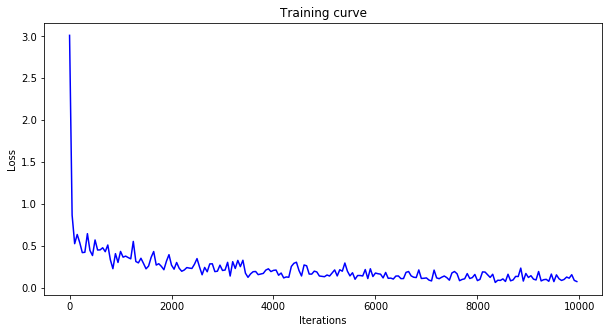

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 0.41741710901260376


In [10]:
try:
    losses = np.array(losses)
    np.save('./train_losses_final.npy', losses)
    print(losses.shape)
except NameError:
    losses = np.load('./train_losses_final.npy')
    
    import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

TEST_BATCH_SIZE = 128

model.test(test_set, test_label_one_hot, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Test sample digit: 9


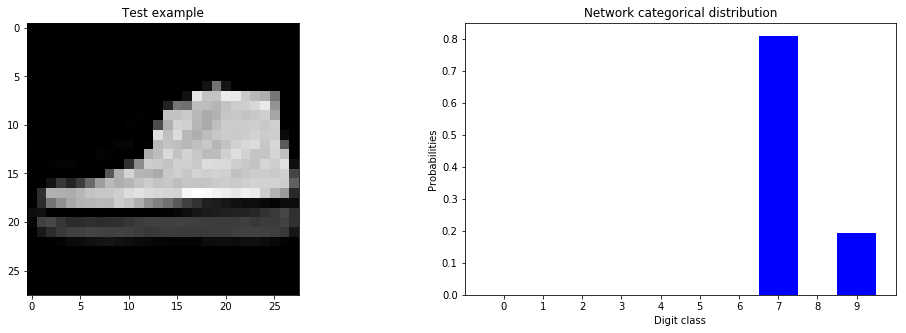

Network prediction probabilities:
[4.0302868e-07 6.5979741e-08 4.3175225e-10 1.2011994e-09 2.8974189e-11
 1.7565653e-06 3.2286464e-06 8.0812609e-01 6.8809243e-08 1.9186835e-01]


In [15]:
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_set[example], axis=0)
label = np.expand_dims(test_label_one_hot[example], axis=0)

category = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label, model.is_training: False}

with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./model.meta")
    saver.restore(sess, './model')
    prediction = sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample category: {}".format(category))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('category class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [16]:
train_time = end_time - start_time
print('total training time :', train_time, 's, or ', int(train_time/60), 'min', train_time%60, 's' )
count = len(tf.global_variables())
print('total parameters involved :', count)

total training time : 1421.6174612045288 s, or  23 min 41.61746120452881 s
total parameters involved : 392


In [21]:
from tensorflow.examples.tutorials.mnist import input_data
help(input_data)
data = input_data.read_data_sets('train_files')
print(data)



Help on module tensorflow.examples.tutorials.mnist.input_data in tensorflow.examples.tutorials.mnist:

NAME
    tensorflow.examples.tutorials.mnist.input_data - Functions for downloading and reading MNIST data.

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...

FILE
    c:\users\user\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\examples\tutorials\mnist\input_data.py


Extracting train_files\train-images-idx3-ubyte.gz
Extracting train_files\train-labels-idx1-ubyte.gz
Extracting train_files\t10k-images-idx3-ubyte.gz
Extracting train_files\t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000001F478B3C588>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000001F478B19080>, test=<tensorflo

In [37]:
n = 100
i = 0
for _ in range(n):
    example = np.random.choice(np.arange(n_test))

    sample = np.expand_dims(test_set[example], axis=0)
    label = np.expand_dims(test_label_one_hot[example], axis=0)

    category = np.where(label[0]==1.0)[0][0]

    feed_dict = {model.input: sample, model.ground_truth: label, model.is_training: False}

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph("./model.meta")
        saver.restore(sess, './model')
        prediction = sess.run(model.prediction, feed_dict=feed_dict)[0]
    p = np.argmax(prediction)
    if p == category:
        i += 1
        
print('success rate: ',i/n*100)


INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model
INFO:tensorflow:Restoring parameters from ./model


In [7]:
import tensorflow as tf
import numpy as np
import os, sys, inspect
import time

utils_folder = os.path.realpath(
    os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0], "..")))
if utils_folder not in sys.path:
    sys.path.insert(0, utils_folder)

import utils as utils
import Dataset_Reader.read_celebADataset as celebA
from six.moves import xrange


class GAN(object):
    def __init__(self, z_dim, crop_image_size, resized_image_size, batch_size, data_dir):
        celebA_dataset = celebA.read_dataset(data_dir)
        self.z_dim = z_dim
        self.crop_image_size = crop_image_size
        self.resized_image_size = resized_image_size
        self.batch_size = batch_size
        filename_queue = tf.train.string_input_producer(celebA_dataset.train_images)
        self.images = self._read_input_queue(filename_queue)

    def _read_input(self, filename_queue):
        class DataRecord(object):
            pass

        reader = tf.WholeFileReader()
        key, value = reader.read(filename_queue)
        record = DataRecord()
        decoded_image = tf.image.decode_jpeg(value,
                                             channels=3)  # Assumption:Color images are read and are to be generated

        # decoded_image_4d = tf.expand_dims(decoded_image, 0)
        # resized_image = tf.image.resize_bilinear(decoded_image_4d, [self.target_image_size, self.target_image_size])
        # record.input_image = tf.squeeze(resized_image, squeeze_dims=[0])

        cropped_image = tf.cast(
            tf.image.crop_to_bounding_box(decoded_image, 55, 35, self.crop_image_size, self.crop_image_size),
            tf.float32)
        decoded_image_4d = tf.expand_dims(cropped_image, 0)
        resized_image = tf.image.resize_bilinear(decoded_image_4d, [self.resized_image_size, self.resized_image_size])
        record.input_image = tf.squeeze(resized_image, squeeze_dims=[0])
        return record

    def _read_input_queue(self, filename_queue):
        print("Setting up image reader...")
        read_input = self._read_input(filename_queue)
        num_preprocess_threads = 4
        num_examples_per_epoch = 800
        min_queue_examples = int(0.1 * num_examples_per_epoch)
        print("Shuffling")
        input_image = tf.train.batch([read_input.input_image],
                                     batch_size=self.batch_size,
                                     num_threads=num_preprocess_threads,
                                     capacity=min_queue_examples + 2 * self.batch_size
                                     )
        input_image = utils.process_image(input_image, 127.5, 127.5)
        return input_image

    def _generator(self, z, dims, train_phase, activation=tf.nn.relu, scope_name="generator"):
        N = len(dims)
        image_size = self.resized_image_size // (2 ** (N - 1))
        with tf.variable_scope(scope_name) as scope:
            W_z = utils.weight_variable([self.z_dim, dims[0] * image_size * image_size], name="W_z")
            b_z = utils.bias_variable([dims[0] * image_size * image_size], name="b_z")
            h_z = tf.matmul(z, W_z) + b_z
            h_z = tf.reshape(h_z, [-1, image_size, image_size, dims[0]])
            h_bnz = utils.batch_norm(h_z, dims[0], train_phase, scope="gen_bnz")
            h = activation(h_bnz, name='h_z')
            utils.add_activation_summary(h)

            for index in range(N - 2):
                image_size *= 2
                W = utils.weight_variable([5, 5, dims[index + 1], dims[index]], name="W_%d" % index)
                b = utils.bias_variable([dims[index + 1]], name="b_%d" % index)
                deconv_shape = tf.pack([tf.shape(h)[0], image_size, image_size, dims[index + 1]])
                h_conv_t = utils.conv2d_transpose_strided(h, W, b, output_shape=deconv_shape)
                h_bn = utils.batch_norm(h_conv_t, dims[index + 1], train_phase, scope="gen_bn%d" % index)
                h = activation(h_bn, name='h_%d' % index)
                utils.add_activation_summary(h)

            image_size *= 2
            W_pred = utils.weight_variable([5, 5, dims[-1], dims[-2]], name="W_pred")
            b_pred = utils.bias_variable([dims[-1]], name="b_pred")
            deconv_shape = tf.pack([tf.shape(h)[0], image_size, image_size, dims[-1]])
            h_conv_t = utils.conv2d_transpose_strided(h, W_pred, b_pred, output_shape=deconv_shape)
            pred_image = tf.nn.tanh(h_conv_t, name='pred_image')
            utils.add_activation_summary(pred_image)

        return pred_image

    def _discriminator(self, input_images, dims, train_phase, activation=tf.nn.relu, scope_name="discriminator",
                       scope_reuse=False):
        N = len(dims)
        with tf.variable_scope(scope_name) as scope:
            if scope_reuse:
                scope.reuse_variables()
            h = input_images
            skip_bn = True  # First layer of discriminator skips batch norm
            for index in range(N - 2):
                W = utils.weight_variable([5, 5, dims[index], dims[index + 1]], name="W_%d" % index)
                b = utils.bias_variable([dims[index + 1]], name="b_%d" % index)
                h_conv = utils.conv2d_strided(h, W, b)
                if skip_bn:
                    h_bn = h_conv
                    skip_bn = False
                else:
                    h_bn = utils.batch_norm(h_conv, dims[index + 1], train_phase, scope="disc_bn%d" % index)
                h = activation(h_bn, name="h_%d" % index)
                utils.add_activation_summary(h)

            shape = h.get_shape().as_list()
            image_size = self.resized_image_size // (2 ** (N - 2))  # dims has input dim and output dim
            h_reshaped = tf.reshape(h, [self.batch_size, image_size * image_size * shape[3]])
            W_pred = utils.weight_variable([image_size * image_size * shape[3], dims[-1]], name="W_pred")
            b_pred = utils.bias_variable([dims[-1]], name="b_pred")
            h_pred = tf.matmul(h_reshaped, W_pred) + b_pred

        return tf.nn.sigmoid(h_pred), h_pred, h

    def _cross_entropy_loss(self, logits, labels, name="x_entropy"):
        xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, labels))
        tf.scalar_summary(name, xentropy)
        return xentropy

    def _get_optimizer(self, optimizer_name, learning_rate, optimizer_param):
        self.learning_rate = learning_rate
        if optimizer_name == "Adam":
            return tf.train.AdamOptimizer(learning_rate, beta1=optimizer_param)
        elif optimizer_name == "RMSProp":
            return tf.train.RMSPropOptimizer(learning_rate, decay=optimizer_param)
        else:
            raise ValueError("Unknown optimizer %s" % optimizer_name)

    def _train(self, loss_val, var_list, optimizer):
        grads = optimizer.compute_gradients(loss_val, var_list=var_list)
        for grad, var in grads:
            utils.add_gradient_summary(grad, var)
        return optimizer.apply_gradients(grads)

    def _setup_placeholder(self):
        self.train_phase = tf.placeholder(tf.bool)
        self.z_vec = tf.placeholder(tf.float32, [self.batch_size, self.z_dim], name="z")

    def _gan_loss(self, logits_real, logits_fake, feature_real, feature_fake, use_features=False):
        discriminator_loss_real = self._cross_entropy_loss(logits_real, tf.ones_like(logits_real),
                                                           name="disc_real_loss")

        discriminator_loss_fake = self._cross_entropy_loss(logits_fake, tf.zeros_like(logits_fake),
                                                           name="disc_fake_loss")
        self.discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        gen_loss_disc = self._cross_entropy_loss(logits_fake, tf.ones_like(logits_fake), name="gen_disc_loss")
        if use_features:
            gen_loss_features = tf.reduce_mean(tf.nn.l2_loss(feature_real - feature_fake)) / (self.crop_image_size ** 2)
        else:
            gen_loss_features = 0
        self.gen_loss = gen_loss_disc + 0.1 * gen_loss_features

        tf.scalar_summary("Discriminator_loss", self.discriminator_loss)
        tf.scalar_summary("Generator_loss", self.gen_loss)

    def create_network(self, generator_dims, discriminator_dims, optimizer="Adam", learning_rate=2e-4,
                       optimizer_param=0.9, improved_gan_loss=True):
        print("Setting up model...")
        self._setup_placeholder()
        tf.histogram_summary("z", self.z_vec)
        self.gen_images = self._generator(self.z_vec, generator_dims, self.train_phase, scope_name="generator")

        tf.image_summary("image_real", self.images, max_images=2)
        tf.image_summary("image_generated", self.gen_images, max_images=2)

        def leaky_relu(x, name="leaky_relu"):
            return utils.leaky_relu(x, alpha=0.2, name=name)

        discriminator_real_prob, logits_real, feature_real = self._discriminator(self.images, discriminator_dims,
                                                                                 self.train_phase,
                                                                                 activation=leaky_relu,
                                                                                 scope_name="discriminator",
                                                                                 scope_reuse=False)

        discriminator_fake_prob, logits_fake, feature_fake = self._discriminator(self.gen_images, discriminator_dims,
                                                                                 self.train_phase,
                                                                                 activation=leaky_relu,
                                                                                 scope_name="discriminator",
                                                                                 scope_reuse=True)

        # utils.add_activation_summary(tf.identity(discriminator_real_prob, name='disc_real_prob'))
        # utils.add_activation_summary(tf.identity(discriminator_fake_prob, name='disc_fake_prob'))

        # Loss calculation
        self._gan_loss(logits_real, logits_fake, feature_real, feature_fake, use_features=improved_gan_loss)

        train_variables = tf.trainable_variables()

        for v in train_variables:
            # print (v.op.name)
            utils.add_to_regularization_and_summary(var=v)

        self.generator_variables = [v for v in train_variables if v.name.startswith("generator")]
        # print(map(lambda x: x.op.name, generator_variables))
        self.discriminator_variables = [v for v in train_variables if v.name.startswith("discriminator")]
        # print(map(lambda x: x.op.name, discriminator_variables))

        optim = self._get_optimizer(optimizer, learning_rate, optimizer_param)

        self.generator_train_op = self._train(self.gen_loss, self.generator_variables, optim)
        self.discriminator_train_op = self._train(self.discriminator_loss, self.discriminator_variables, optim)

    def initialize_network(self, logs_dir):
        print("Initializing network...")
        self.logs_dir = logs_dir
        self.sess = tf.Session()
        self.summary_op = tf.merge_all_summaries()
        self.saver = tf.train.Saver()
        self.summary_writer = tf.train.SummaryWriter(self.logs_dir, self.sess.graph)

        self.sess.run(tf.initialize_all_variables())
        ckpt = tf.train.get_checkpoint_state(self.logs_dir)
        if ckpt and ckpt.model_checkpoint_path:
            self.saver.restore(self.sess, ckpt.model_checkpoint_path)
            print("Model restored...")
        self.coord = tf.train.Coordinator()
        self.threads = tf.train.start_queue_runners(self.sess, self.coord)

    def train_model(self, max_iterations):
        try:
            print("Training model...")
            for itr in xrange(1, max_iterations):
                batch_z = np.random.uniform(-1.0, 1.0, size=[self.batch_size, self.z_dim]).astype(np.float32)
                feed_dict = {self.z_vec: batch_z, self.train_phase: True}

                self.sess.run(self.discriminator_train_op, feed_dict=feed_dict)
                self.sess.run(self.generator_train_op, feed_dict=feed_dict)

                if itr % 10 == 0:
                    g_loss_val, d_loss_val, summary_str = self.sess.run(
                        [self.gen_loss, self.discriminator_loss, self.summary_op], feed_dict=feed_dict)
                    print("Step: %d, generator loss: %g, discriminator_loss: %g" % (itr, g_loss_val, d_loss_val))
                    self.summary_writer.add_summary(summary_str, itr)

                if itr % 2000 == 0:
                    self.saver.save(self.sess, self.logs_dir + "model.ckpt", global_step=itr)

        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        except KeyboardInterrupt:
            print("Ending Training...")
        finally:
            self.coord.request_stop()
            self.coord.join(self.threads)  # Wait for threads to finish.

    def visualize_model(self):
        print("Sampling images from model...")
        batch_z = np.random.uniform(-1.0, 1.0, size=[self.batch_size, self.z_dim]).astype(np.float32)
        feed_dict = {self.z_vec: batch_z, self.train_phase: False}

        images = self.sess.run(self.gen_images, feed_dict=feed_dict)
        images = utils.unprocess_image(images, 127.5, 127.5).astype(np.uint8)
        shape = [4, self.batch_size // 4]
        utils.save_imshow_grid(images, self.logs_dir, "generated.png", shape=shape)


class WasserstienGAN(GAN):
    def __init__(self, z_dim, crop_image_size, resized_image_size, batch_size, data_dir, clip_values=(-0.01, 0.01),
                 critic_iterations=5):
        self.critic_iterations = critic_iterations
        self.clip_values = clip_values
        GAN.__init__(self, z_dim, crop_image_size, resized_image_size, batch_size, data_dir)

    def _generator(self, z, dims, train_phase, activation=tf.nn.relu, scope_name="generator"):
        N = len(dims)
        image_size = self.resized_image_size // (2 ** (N - 1))
        with tf.variable_scope(scope_name) as scope:
            W_z = utils.weight_variable([self.z_dim, dims[0] * image_size * image_size], name="W_z")
            h_z = tf.matmul(z, W_z)
            h_z = tf.reshape(h_z, [-1, image_size, image_size, dims[0]])
            h_bnz = utils.batch_norm(h_z, dims[0], train_phase, scope="gen_bnz")
            h = activation(h_bnz, name='h_z')
            utils.add_activation_summary(h)

            for index in range(N - 2):
                image_size *= 2
                W = utils.weight_variable([4, 4, dims[index + 1], dims[index]], name="W_%d" % index)
                b = tf.zeros([dims[index + 1]])
                deconv_shape = tf.pack([tf.shape(h)[0], image_size, image_size, dims[index + 1]])
                h_conv_t = utils.conv2d_transpose_strided(h, W, b, output_shape=deconv_shape)
                h_bn = utils.batch_norm(h_conv_t, dims[index + 1], train_phase, scope="gen_bn%d" % index)
                h = activation(h_bn, name='h_%d' % index)
                utils.add_activation_summary(h)

            image_size *= 2
            W_pred = utils.weight_variable([4, 4, dims[-1], dims[-2]], name="W_pred")
            b = tf.zeros([dims[-1]])
            deconv_shape = tf.pack([tf.shape(h)[0], image_size, image_size, dims[-1]])
            h_conv_t = utils.conv2d_transpose_strided(h, W_pred, b, output_shape=deconv_shape)
            pred_image = tf.nn.tanh(h_conv_t, name='pred_image')
            utils.add_activation_summary(pred_image)

        return pred_image

    def _discriminator(self, input_images, dims, train_phase, activation=tf.nn.relu, scope_name="discriminator",
                       scope_reuse=False):
        N = len(dims)
        with tf.variable_scope(scope_name) as scope:
            if scope_reuse:
                scope.reuse_variables()
            h = input_images
            skip_bn = True  # First layer of discriminator skips batch norm
            for index in range(N - 2):
                W = utils.weight_variable([4, 4, dims[index], dims[index + 1]], name="W_%d" % index)
                b = tf.zeros([dims[index+1]])
                h_conv = utils.conv2d_strided(h, W, b)
                if skip_bn:
                    h_bn = h_conv
                    skip_bn = False
                else:
                    h_bn = utils.batch_norm(h_conv, dims[index + 1], train_phase, scope="disc_bn%d" % index)
                h = activation(h_bn, name="h_%d" % index)
                utils.add_activation_summary(h)

            W_pred = utils.weight_variable([4, 4, dims[-2], dims[-1]], name="W_pred")
            b = tf.zeros([dims[-1]])
            h_pred = utils.conv2d_strided(h, W_pred, b)
        return None, h_pred, None  # Return the last convolution output. None values are returned to maintatin disc from other GAN

    def _gan_loss(self, logits_real, logits_fake, feature_real, feature_fake, use_features=False):
        self.discriminator_loss = tf.reduce_mean(logits_real - logits_fake)
        self.gen_loss = tf.reduce_mean(logits_fake)

        tf.scalar_summary("Discriminator_loss", self.discriminator_loss)
        tf.scalar_summary("Generator_loss", self.gen_loss)

    def train_model(self, max_iterations):
        try:
            print("Training Wasserstein GAN model...")
            clip_discriminator_var_op = [var.assign(tf.clip_by_value(var, self.clip_values[0], self.clip_values[1])) for
                                         var in self.discriminator_variables]

            start_time = time.time()

            def get_feed_dict(train_phase=True):
                batch_z = np.random.uniform(-1.0, 1.0, size=[self.batch_size, self.z_dim]).astype(np.float32)
                feed_dict = {self.z_vec: batch_z, self.train_phase: train_phase}
                return feed_dict

            for itr in xrange(1, max_iterations):
                if itr < 25 or itr % 500 == 0:
                    critic_itrs = 25
                else:
                    critic_itrs = self.critic_iterations

                for critic_itr in range(critic_itrs):
                    self.sess.run(self.discriminator_train_op, feed_dict=get_feed_dict(True))
                    self.sess.run(clip_discriminator_var_op)

                feed_dict = get_feed_dict(True)
                self.sess.run(self.generator_train_op, feed_dict=feed_dict)

                if itr % 100 == 0:
                    summary_str = self.sess.run(self.summary_op, feed_dict=feed_dict)
                    self.summary_writer.add_summary(summary_str, itr)

                if itr % 200 == 0:
                    stop_time = time.time()
                    duration = (stop_time - start_time) / 200.0
                    start_time = stop_time
                    g_loss_val, d_loss_val = self.sess.run([self.gen_loss, self.discriminator_loss],
                                                           feed_dict=feed_dict)
                    print("Time: %g/itr, Step: %d, generator loss: %g, discriminator_loss: %g" % (
                        duration, itr, g_loss_val, d_loss_val))

                if itr % 5000 == 0:
                    self.saver.save(self.sess, self.logs_dir + "model.ckpt", global_step=itr)

        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        except KeyboardInterrupt:
            print("Ending Training...")
        finally:
            self.coord.request_stop()
            self.coord.join(self.threads)  # Wait for threads to finish.

ModuleNotFoundError: No module named 'utils'